In [156]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandana.loaders import osm
import pandana
%pylab inline

import numpy as np
import osmnx as ox
import networkx as nx
import peartree
import sys, os
import geopandas as gpd
import rasterio
from pandana.loaders import osm
from shapely.geometry import Point
#import mplleaflet as mpll
from osgeo import ogr
from math import ceil, cos, pi
import geocoder

import GOSTnet as gn
from make_fishnet import make_fishnet
from rasterio.features import rasterize
from rasterio.plot import show

Populating the interactive namespace from numpy and matplotlib


### Workflow to plot time to nearest N amenity for cities
* Map it as a smooth travel time surface
* Include walk time to nearest node
* Do OD calculations from each pixel to the set of nearest nodes
* Burn it back into a raster

In [6]:
boundary_GDF = ox.gdf_from_place("Ulaan Baatar")

In [4]:
boundary_GDF.to_file('data/Piedmont_geo')

# then in GIS, rasterize it and turn it into points

In [2]:
PIED_raster = rasterio.open('data/PIED_raster.tif')

In [5]:
boundary_poly = boundary_GDF.loc[0,'geometry']
coords = (boundary_poly.bounds[1], boundary_poly.bounds[0], boundary_poly.bounds[3], boundary_poly.bounds[2])
coords

(37.812276, -122.249374, 37.833026, -122.210148)

#### 2. Get POIs, road network

In [7]:
# RESIDENTIAL AMENITIES

residential_amenities = ['restaurant','bank','atm','cafe','bus_station','fast_food','pharmacy','school',
                        'kindergarten','pub','hospital','bar','marketplace','dentist','place_of_worship']

residential_shops = ['supermarket','yes','hairdresser','convenience','clothes','beauty','bakery']
residential_leisure = ['park','playground','sports_centre','pitch']

POIs_res_amenity = osm.node_query(coords[0], coords[1], coords[2], coords[3],tags = '"amenity"~"{}"'.format('|'.join(residential_amenities)))
POIs_res_shop = osm.node_query(coords[0], coords[1], coords[2], coords[3],tags = '"shop"~"{}"'.format('|'.join(residential_shops)))
POIs_res_leisure = osm.node_query(coords[0], coords[1], coords[2], coords[3],tags = '"leisure"~"{}"'.format('|'.join(residential_leisure)))

POIs_res_amenity = POIs_res_amenity[['amenity','name','lat','lon']]
POIs_res_amenity.rename(columns={'amenity':'type'},inplace=True)

POIs_res_shop = POIs_res_shop[['shop','name','lat','lon']]
POIs_res_shop.rename(columns={'shop':'type'},inplace=True)

POIs_res_leisure = POIs_res_leisure[['leisure','name','lat','lon']]
POIs_res_leisure.rename(columns={'leisure':'type'},inplace=True)

pois_res = POIs_res_amenity.append(POIs_res_shop)
pois_res = pois_res.append(POIs_res_leisure)

In [8]:
pois_res.head(1)

type                              name        lat         lon
id                                                                        
358819251  school  Millennium Alternate High School  37.822905 -122.233678

In [9]:
pois_res = gpd.GeoDataFrame(pois_res)
pois_res['geometry'] = (list(zip(pois_res.lon,pois_res.lat)))
pois_res['geometry'] = pois_res.geometry.apply(lambda x: Point(x))

In [10]:
pois_res['type'].value_counts().head()

restaurant     14
hairdresser     5
school          3
pub             3
convenience     3
Name: type, dtype: int64

#### 3. Create graph
* Convert to time


In [12]:
# Create graph
G = ox.graph_from_polygon(boundary_poly, network_type = 'drive')

In [13]:
G = ox.project_graph(G)

In [14]:
G = gn.convert_network_to_time(G, distance_tag = 'length')

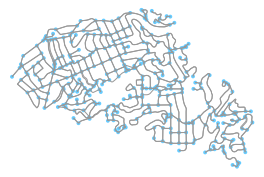

In [15]:
ox.plot_graph(G, fig_height=3);

#### 4. Import origin points

In [16]:
area_points = gpd.read_file('data/PIED_points')
area_points.head

(64608, 3)

In [46]:
pois_res.head()

type                              name        lat  \
id                                                                         
358819251            school  Millennium Alternate High School  37.822905   
358819659            school             Corpus Christi School  37.813816   
358819746  place_of_worship              Zion Lutheran Church  37.818648   
358819748            school              Zion Lutheran School  37.818619   
358851430  place_of_worship       Kehilla Community Synagogue  37.820205   

                  lon                         geometry  
id                                                      
358819251 -122.233678  POINT (-122.2336783 37.8229051)  
358819659 -122.214412  POINT (-122.2144122 37.8138162)  
358819746 -122.210493  POINT (-122.2104929 37.8186477)  
358819748 -122.211076  POINT (-122.2110762 37.8186188)  
358851430 -122.243858  POINT (-122.2438577 37.8202051)

#### 5. Attach nearest nodes to Os and Ds (plus get the walk-time to NN)

In [44]:
import pyproj

In [63]:
area_points.head()

pointid   grid_code                                      geometry
0        1 -122.210148  POINT (-122.2281674999999 37.83298450000001)
1        2 -122.210148        POINT (-122.2280845 37.83298450000001)
2        3 -122.210148   POINT (-122.2284164999999 37.8329015000001)
3        4 -122.210148         POINT (-122.2283335 37.8329015000001)
4        5 -122.210148   POINT (-122.2282504999999 37.8329015000001)

In [80]:
pois_res.crs = {'init': 'epsg:4326'}

In [78]:
area_points['geometry'] = area_points['geometry'].to_crs(epsg=32610)

In [81]:
pois_res['geometry'] = pois_res['geometry'].to_crs(epsg=32610)

In [72]:
# Origins
area_points = gn.pandana_snap(G, area_points, add_dist_to_node_col=True, source_crs='epsg:32610', target_crs = 'epsg:32610')

In [99]:
area_points.head()

pointid   grid_code                                     geometry  \
0        1 -122.210148   POINT (567918.7421216241 4187565.16944725)   
1        2 -122.210148  POINT (567926.0459613923 4187565.229802944)   
2        3 -122.210148  POINT (567896.9066726448 4187555.779449839)   
3        4 -122.210148  POINT (567904.2105204904 4187555.839786015)   
4        5 -122.210148  POINT (567911.5143683783 4187555.900128682)   

                                     projected        NN     NN_dist  \
0   POINT (567918.7421216241 4187565.16944725)  53065785  143.270659   
1  POINT (567926.0459613923 4187565.229802944)  53065785  142.430574   
2  POINT (567896.9066726448 4187555.779449839)  53065785  139.135738   
3  POINT (567904.2105204904 4187555.839786015)  53065785  137.108117   
4  POINT (567911.5143683783 4187555.900128682)  53065785  135.444525   

   min_travel_time  
0         4.593243  
1         4.593243  
2         4.593243  
3         4.593243  
4         4.593243

In [82]:
# Destinations
pois_res = gn.pandana_snap(G, pois_res, add_dist_to_node_col=True, source_crs= 'epsg:32610', target_crs = 'epsg:32610')

#### 6. Calculate travel times

In [84]:
OD = gn.calculate_OD(G, list(area_points.NN), list(pois_res.NN), 0, weight='time')

In [91]:
min_travel_times = OD.min(axis = 1)

In [116]:
walk_time = ((area_points.NN_dist / 1000 ) / 4.5) * 60 * 60

In [118]:
area_points['min_travel_time'] = (min_travel_times + walk_time) / 60

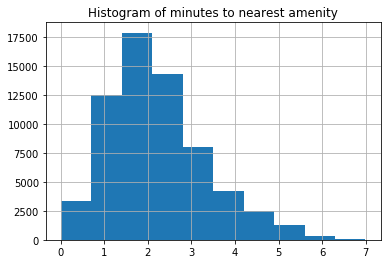

In [120]:
area_points.min_travel_time.hist()
plt.title('Histogram of minutes to nearest amenity');

In [147]:
area_points.columns

Index(['pointid', 'grid_code', 'geometry', 'projected', 'NN', 'NN_dist',
       'min_travel_time'],
      dtype='object')

In [148]:
area_points.set_geometry('geometry',inplace=True)

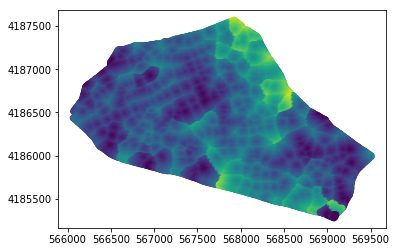

In [151]:
area_points.plot(column='min_travel_time')

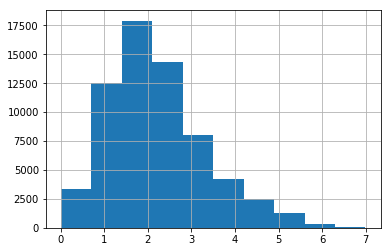

In [215]:
area_points.min_travel_time.hist()

In [ ]:
rst_fn = os.path.join(pth,'PIED_raster.tif')
out_fn = os.path.join(pth,'PIED_travel_time.tif')

# Update metadata
rst = rasterio.open(rst_fn, 'r')
meta = rst.meta.copy()
D_type = rasterio.float64
meta.update(compress='lzw', dtype = D_type, count = 2)

with rasterio.open(out_fn, 'w', **meta) as out:
    with rasterio.open(rst_fn, 'r') as pop:
        
        # this is where we create a generator of geom, value pairs to use in rasterizing
        shapes = ((geom,value) for geom, value in zip(area_points.geometry, area_points.min_travel_time))
        
        rst1 = rst.read(1).astype(D_type)
        cpy = rst1.copy()

        travel_times = rasterize(shapes=shapes, fill=0, out=cpy, transform=out.transform)

        out.write_band(1, travel_times)

In [232]:
rst.crs

CRS.from_dict(init='epsg:4326')

#### 7. Rasterize

In [121]:
pth = 'data'

In [181]:
rst_fn = os.path.join(pth,'PIED_raster.tif')
out_fn = os.path.join(pth,'PIED_travel_time.tif')

# Update metadata
rst = rasterio.open(rst_fn, 'r')
meta = rst.meta.copy()
D_type = rasterio.float64
meta.update(compress='lzw', dtype = D_type, count = 2)

with rasterio.open(out_fn, 'w', **meta) as out:
    with rasterio.open(rst_fn, 'r') as pop:
        
        # this is where we create a generator of geom, value pairs to use in rasterizing
        shapes = ((geom,value) for geom, value in zip(area_points.geometry, area_points.min_travel_time))
        
        rst1 = rst.read(1).astype(D_type)
        cpy = rst1.copy()

        travel_times = rasterize(shapes=shapes, fill=0, out=cpy, transform=out.transform)

        out.write_band(1, travel_times)

In [182]:
tt = rasterio.open(os.path.join(pth, 'PIED_travel_time.tif'))

In [187]:
tt.count

2

In [230]:
rast_arr = tt.read(1)

In [210]:
rast_arr[rast_arr < 10].sum()

0.0

In [214]:
pd.DataFrame(rast_arr)

0    1    2    3    4    5    6    7    8    9    ...  463  464  465  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
5    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
6    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
7    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
8    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
10   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
11   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
12   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
13   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
14   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
15   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
16   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
17   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
18   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
19   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
20   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
21   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
22   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
23   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
24   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
25   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
27   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
28   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
29   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
220  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
221  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
222  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
223  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
224  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
225  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
226  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
227  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
228  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
229  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
230  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
231  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
232  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
233  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
234  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
235  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
236  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
237  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
238  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
239  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2

In [198]:
f,ax = plt.subplots(figsize = [9,6])

#im = show(tt, ax = ax, cmap=plt.cm.jet)
im = plt.imshow(rast_arr, cmap=plt.cm.jet)

# Add a colorbar
f.colorbar(im, ax=ax)
plt.title("Random town in California - Minutes drive to nearest amenity")

Text(0.5, 1.0, 'Random town in California - Minutes drive to nearest amenity')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1181561e0> (for post_execute):


ValueError: arange: cannot compute length

ValueError: arange: cannot compute length